# Omission LFP Analysis

Brief 1-2 sentence description of notebook.

In [1]:
import os
import glob
from collections import defaultdict
import re

In [2]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy import stats
import itertools

In [118]:
import spikeinterface.extractors as se
import spikeinterface.preprocessing as sp
from spectral_connectivity import Multitaper, Connectivity
import spectral_connectivity

## Inputs & Data

Explanation of each input and where it comes from.

In [4]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case

In [5]:
BBOX_TO_ANCHOR=(1.5, 0.9)
LOC='upper right'

In [6]:
# variables for LFP extraction
FREQ_MIN=0.5
FREQ_MAX=300
FREQ=60
RESAMPLE_RATE=1000
TRIAL_DURATION=10

In [7]:
INPUT_VARIABLE = 1

TIME_HALFBANDWIDTH_PRODUCT = 2
TIME_WINDOW_DURATION = 3
TIME_WINDOW_STEP = 1.5 

TRIAL_TIME_STAMP_DURATION = 1000*10

In [8]:
BIN_TO_COLOR = {0: {"baseline": "lightblue", "trial": "blue"}, 1: {"baseline": "lightgreen", "trial": "green"}, 2: {"baseline": "lightcoral", "trial": "red"}}
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}
BIN_TO_VELOCITY = {0: "0 to 2.5cm/s", 1: "2.5 to 5cm/s", 2: "5cm/s+"}

In [9]:
NUM_LINES = 3

In [10]:
# Generate colors from the "Blues" colormap
LOSING_COLORS = cm.Oranges(np.linspace(0.5, 1, NUM_LINES))
# Generate colors from the "Blues" colormap
WINNING_COLORS = cm.Blues(np.linspace(0.5, 1, NUM_LINES))
# Generate colors from the "Blues" colormap
REWARDED_COLORS = cm.Greens(np.linspace(0.5, 1, NUM_LINES))
# Generate colors from the "Blues" colormap
OMISSION_COLORS = cm.Reds(np.linspace(0.5, 1, NUM_LINES))

In [11]:
BASELINE_OUTCOME_TO_COLOR = {'lose': "orange",
 'lose_baseline': LOSING_COLORS[0],
 'omission': "red",
 'omission_baseline': "hotpink",
 'rewarded': "green",
 'rewarded_baseline': REWARDED_COLORS[0],
 'win': "blue",
 'win_baseline': WINNING_COLORS[0]}

In [12]:
COMPETITIVE_OUTCOME_TO_COLOR = {'lose_comp': "orange", 
'lose_non_comp': "yellow",
'omission': "red",
'rewarded': "green",
'win_comp': "blue", 
'win_non_comp': WINNING_COLORS[0]}

In [13]:
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}

In [14]:
CHANNEL_MAPPING_DF = pd.read_excel("../../channel_mapping.xlsx")
CHANNEL_MAPPING_DF["Subject"] = CHANNEL_MAPPING_DF["Subject"].astype(str)

TONE_TIMESTAMP_DF = pd.read_excel("../../rce_tone_timestamp.xlsx", index_col=0)
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs


In [15]:
all_session_dir = ['/scratch/back_up/reward_competition_extention/data/standard/2023_06_12/20230612_101430_standard_comp_to_training_D1_subj_1-4_and_1-3.rec',
'/scratch/back_up/reward_competition_extention/data/omission/2023_06_20/20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1.rec',
'/scratch/back_up/reward_competition_extention/data/pilot/20221214_125409_om_and_comp_6_1_and_6_3.rec',
'/scratch/back_up/reward_competition_extention/data/pilot/20221215_145401_comp_amd_om_6_1_and_6_3.rec',
'/scratch/back_up/reward_competition_extention/data/omission/2023_06_18/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.rec']

In [16]:
all_session_dir

['/scratch/back_up/reward_competition_extention/data/standard/2023_06_12/20230612_101430_standard_comp_to_training_D1_subj_1-4_and_1-3.rec',
 '/scratch/back_up/reward_competition_extention/data/omission/2023_06_20/20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1.rec',
 '/scratch/back_up/reward_competition_extention/data/pilot/20221214_125409_om_and_comp_6_1_and_6_3.rec',
 '/scratch/back_up/reward_competition_extention/data/pilot/20221215_145401_comp_amd_om_6_1_and_6_3.rec',
 '/scratch/back_up/reward_competition_extention/data/omission/2023_06_18/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.rec']

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Functions

- Ideally functions are defined here first and then data is processed using the functions
    - function names are short and in snake case all lowercase
    - a function name should be unique but does not have to describe the function
    - doc strings describe functions not function names

In [113]:
def generate_pairs(lst):
    pairs = []
    n = len(lst)
    for i in range(n):
        for j in range(i+1, n):
            pairs.append((lst[i], lst[j]))
    return pairs

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [17]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

In [18]:
CHANNEL_MAPPING_DF

,Cohort,Subject,eib_mPFC,eib_vHPC,eib_BLA,eib_LH,eib_MD,spike_interface_mPFC,spike_interface_vHPC,spike_interface_BLA,spike_interface_LH,spike_interface_MD
0,1,6.1,NaN,15,14,13,31,21.0,15.0,14.0,13.0,16.0
1,1,6.2,NaN,15,14,13,31,NaN,NaN,NaN,NaN,NaN
2,1,6.3,NaN,15,14,13,31,NaN,NaN,NaN,NaN,NaN
3,1,6.4,NaN,15,14,13,31,NaN,NaN,NaN,NaN,NaN
4,2,1.1,NaN,16,17,18,19,5.0,31.0,30.0,29.0,28.0
5,2,1.2,NaN,31,30,29,28,10.0,31.0,30.0,29.0,28.0
6,2,1.3,NaN,15,14,13,12,9.0,31.0,30.0,29.0,28.0
7,2,1.4,NaN,15,14,13,12,15.0,31.0,30.0,29.0,28.0


### Getting the subject IDs from the file name

In [19]:
TONE_TIMESTAMP_DF = pd.read_pickle("./proc/melted_trials_and_video.pkl")


In [20]:
all_trials_df = TONE_TIMESTAMP_DF.dropna(subset="condition").reset_index(drop=True)

In [21]:
all_trials_df.head()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,...,trial_chunked_ephys_timestamp,baseline_chunked_ephys_timestamp,trial_chunked_lfp_index,baseline_chunked_lfp_index,trial_or_baseline,current_thorax_velocity,current_chunked_thorax_velocity,chunked_lfp_index,chunked_ephys_timestamp,binned_current_thorax_velocity
0,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,"[(1099250, 1119250), (1119250, 1139250), (1139...","[(899250, 919250), (919250, 939250), (939250, ...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(44962, 45962), (45962, 46962), (46962, 47962...",baseline,"[0.33367330724769034, 0.32906494406630954, 0.3...","[0.43638923644394456, 0.5639966810493696, 0.57...","[(44962, 45962), (45962, 46962), (46962, 47962...","[(899250, 919250), (919250, 939250), (939250, ...","[0, 0, 0, 0, 0, 1, 2, 2, 2, 2]"
1,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,"[(1099250, 1119250), (1119250, 1139250), (1139...","[(899250, 919250), (919250, 939250), (939250, ...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(44962, 45962), (45962, 46962), (46962, 47962...",trial,"[31.2827964314206, 24.845166456174645, 18.6711...","[9.873337358573975, 7.055864053204467, 0.39102...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(1099250, 1119250), (1119250, 1139250), (1139...","[2, 2, 0, 0, 1, 2, 2, 1, 2, 2]"
2,4334936,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,3499256,20230618_100636_standard_comp_to_omission_D2_s...,3492,1,1_1_t1b2L_box2,...,"[(3499256, 3519256), (3519256, 3539256), (3539...","[(3299256, 3319256), (3319256, 3339256), (3339...","[(174962, 175962), (175962, 176962), (176962, ...","[(164962, 165962), (165962, 166962), (166962, ...",baseline,"[0.7987128002646031, 0.8394469016952293, 0.845...","[0.8478014795615629, 1.225847562493769, 1.2524...","[(164962, 165962), (165962, 166962), (166962, ...","[(3299256, 3319256), (3319256, 3339256), (3339...","[0, 0, 0, 0, 0, 0, 2, 1, 2, 2]"
3,4334936,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,3499256,20230618_100636_standard_comp_to_omission_D2_s...,3492,1,1_1_t1b2L_box2,...,"[(3499256, 3519256), (3519256, 3539256), (3539...","[(3299256, 3319256), (3319256, 3339256), (3339...","[(174962, 175962), (175962, 176962), (176962, ...","[(164962, 165962), (165962, 166962), (166962, ...",trial,"[10.998813138399665, 10.092879237226757, 9.555...","[6.20912009533163, 3.1460093621391327, 1.76285...","[(174962, 175962), (175962, 176962), (176962, ...","[(3499256, 3519256), (3519256, 3539256), (3539...","[2, 1, 0, 1, 2, 0, 0, 0, 0, 0]"
4,6634931,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,5799251,20230618_100636_standard_comp_to_omission_D2_s...,5788,1,1_1_t1b2L_box2,...,"[(5799251, 5819251), (5819251, 5839251), (5839...","[(5599251, 5619251), (5619251, 5639251), (5639...","[(289962, 290962), (290962, 291962), (291962, ...","[(279962, 280962), (280962, 281962), (281962, ...",baseline,"[1.1035883660509216, 1.103912980719602, 1.1008...","[0.6305645270264292, 0.7913440867553568, 4.059...","[(279962, 280962), (280962, 281962), (281962, ...","[(5599251, 5619251), (5619251, 5639251), (5639...","[0, 0, 1, 0, 1, 0, 1, 1, 1, 0]"


- Original timestamps are based on ephys recordings at 20kHz. The LFP will be at 1kHz, so we will need to divide all the timestamps by 20

In [22]:
all_trials_df["resampled_index"] = all_trials_df["time_stamp_index"] // 20

In [23]:
all_trials_df["recording_dir"].unique()

array(['20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1'],
      dtype=object)

- Getting a list of all the subjects through the recording name

In [24]:
all_trials_df["all_subjects"] = all_trials_df["recording_dir"].apply(lambda x: ["{}.{}".format(tup[0],tup[1]) for tup in re.findall(r'(\d+)-(\d+)', x.replace("_", "-"))[1:]])

In [25]:
all_trials_df["all_subjects"].head()

0    [1.4, 1.1]
1    [1.4, 1.1]
2    [1.4, 1.1]
3    [1.4, 1.1]
4    [1.4, 1.1]
Name: all_subjects, dtype: object

- Getting the current subject of the recording through the ending of the recording name file

In [26]:
all_trials_df["subject_info"].head()

0    1_1_t1b2L_box2
1    1_1_t1b2L_box2
2    1_1_t1b2L_box2
3    1_1_t1b2L_box2
4    1_1_t1b2L_box2
Name: subject_info, dtype: object

In [27]:
all_trials_df["current_subject"] = all_trials_df["subject_info"].apply(lambda x: ".".join(x.replace("-","_").split("_")[:2]))

In [28]:
all_trials_df.head()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,...,trial_chunked_ephys_timestamp,baseline_chunked_ephys_timestamp,trial_chunked_lfp_index,baseline_chunked_lfp_index,trial_or_baseline,current_thorax_velocity,current_chunked_thorax_velocity,chunked_lfp_index,chunked_ephys_timestamp,binned_current_thorax_velocity
0,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,"[(1099250, 1119250), (1119250, 1139250), (1139...","[(899250, 919250), (919250, 939250), (939250, ...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(44962, 45962), (45962, 46962), (46962, 47962...",baseline,"[0.33367330724769034, 0.32906494406630954, 0.3...","[0.43638923644394456, 0.5639966810493696, 0.57...","[(44962, 45962), (45962, 46962), (46962, 47962...","[(899250, 919250), (919250, 939250), (939250, ...","[0, 0, 0, 0, 0, 1, 2, 2, 2, 2]"
1,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,"[(1099250, 1119250), (1119250, 1139250), (1139...","[(899250, 919250), (919250, 939250), (939250, ...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(44962, 45962), (45962, 46962), (46962, 47962...",trial,"[31.2827964314206, 24.845166456174645, 18.6711...","[9.873337358573975, 7.055864053204467, 0.39102...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(1099250, 1119250), (1119250, 1139250), (1139...","[2, 2, 0, 0, 1, 2, 2, 1, 2, 2]"
2,4334936,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,3499256,20230618_100636_standard_comp_to_omission_D2_s...,3492,1,1_1_t1b2L_box2,...,"[(3499256, 3519256), (3519256, 3539256), (3539...","[(3299256, 3319256), (3319256, 3339256), (3339...","[(174962, 175962), (175962, 176962), (176962, ...","[(164962, 165962), (165962, 166962), (166962, ...",baseline,"[0.7987128002646031, 0.8394469016952293, 0.845...","[0.8478014795615629, 1.225847562493769, 1.2524...","[(164962, 165962), (165962, 166962), (166962, ...","[(3299256, 3319256), (3319256, 3339256), (3339...","[0, 0, 0, 0, 0, 0, 2, 1, 2, 2]"
3,4334936,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,3499256,20230618_100636_standard_comp_to_omission_D2_s...,3492,1,1_1_t1b2L_box2,...,"[(3499256, 3519256), (3519256, 3539256), (3539...","[(3299256, 3319256), (3319256, 3339256), (3339...","[(174962, 175962), (175962, 176962), (176962, ...","[(164962, 165962), (165962, 166962), (166962, ...",trial,"[10.998813138399665, 10.092879237226757, 9.555...","[6.20912009533163, 3.1460093621391327, 1.76285...","[(174962, 175962), (175962, 176962), (176962, ...","[(3499256, 3519256), (3519256, 3539256), (3539...","[2, 1, 0, 1, 2, 0, 0, 0, 0, 0]"
4,6634931,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,5799251,20230618_100636_standard_comp_to_omission_D2_s...,5788,1,1_1_t1b2L_box2,...,"[(5799251, 5819251), (5819251, 5839251), (5839...","[(5599251, 5619251), (5619251, 5639251), (5639...","[(289962, 290962), (290962, 291962), (291962, ...","[(279962, 280962), (280962, 281962), (281962, ...",baseline,"[1.1035883660509216, 1.103912980719602, 1.1008...","[0.6305645270264292, 0.7913440867553568, 4.059...","[(279962, 280962), (280962, 281962), (281962, ...","[(5599251, 5619251), (5619251, 5639251), (5639...","[0, 0, 1, 0, 1, 0, 1, 1, 1, 0]"


- Labeling the trial as a winner or loser if the winner matches the subject id or not

In [29]:
all_trials_df["trial_outcome"] = all_trials_df.apply(
    lambda x: "win" if str(x["condition"]).strip() == str(x["current_subject"]) 
             else ("lose" if str(x["condition"]) in x["all_subjects"] 
                   else x["condition"]), axis=1)

In [30]:
all_trials_df.head()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,...,trial_chunked_ephys_timestamp,baseline_chunked_ephys_timestamp,trial_chunked_lfp_index,baseline_chunked_lfp_index,trial_or_baseline,current_thorax_velocity,current_chunked_thorax_velocity,chunked_lfp_index,chunked_ephys_timestamp,binned_current_thorax_velocity
0,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,"[(1099250, 1119250), (1119250, 1139250), (1139...","[(899250, 919250), (919250, 939250), (939250, ...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(44962, 45962), (45962, 46962), (46962, 47962...",baseline,"[0.33367330724769034, 0.32906494406630954, 0.3...","[0.43638923644394456, 0.5639966810493696, 0.57...","[(44962, 45962), (45962, 46962), (46962, 47962...","[(899250, 919250), (919250, 939250), (939250, ...","[0, 0, 0, 0, 0, 1, 2, 2, 2, 2]"
1,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,"[(1099250, 1119250), (1119250, 1139250), (1139...","[(899250, 919250), (919250, 939250), (939250, ...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(44962, 45962), (45962, 46962), (46962, 47962...",trial,"[31.2827964314206, 24.845166456174645, 18.6711...","[9.873337358573975, 7.055864053204467, 0.39102...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(1099250, 1119250), (1119250, 1139250), (1139...","[2, 2, 0, 0, 1, 2, 2, 1, 2, 2]"
2,4334936,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,3499256,20230618_100636_standard_comp_to_omission_D2_s...,3492,1,1_1_t1b2L_box2,...,"[(3499256, 3519256), (3519256, 3539256), (3539...","[(3299256, 3319256), (3319256, 3339256), (3339...","[(174962, 175962), (175962, 176962), (176962, ...","[(164962, 165962), (165962, 166962), (166962, ...",baseline,"[0.7987128002646031, 0.8394469016952293, 0.845...","[0.8478014795615629, 1.225847562493769, 1.2524...","[(164962, 165962), (165962, 166962), (166962, ...","[(3299256, 3319256), (3319256, 3339256), (3339...","[0, 0, 0, 0, 0, 0, 2, 1, 2, 2]"
3,4334936,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,3499256,20230618_100636_standard_comp_to_omission_D2_s...,3492,1,1_1_t1b2L_box2,...,"[(3499256, 3519256), (3519256, 3539256), (3539...","[(3299256, 3319256), (3319256, 3339256), (3339...","[(174962, 175962), (175962, 176962), (176962, ...","[(164962, 165962), (165962, 166962), (166962, ...",trial,"[10.998813138399665, 10.092879237226757, 9.555...","[6.20912009533163, 3.1460093621391327, 1.76285...","[(174962, 175962), (175962, 176962), (176962, ...","[(3499256, 3519256), (3519256, 3539256), (3539...","[2, 1, 0, 1, 2, 0, 0, 0, 0, 0]"
4,6634931,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,5799251,20230618_100636_standard_comp_to_omission_D2_s...,5788,1,1_1_t1b2L_box2,...,"[(5799251, 5819251), (5819251, 5839251), (5839...","[(5599251, 5619251), (5619251, 5639251), (5639...","[(289962, 290962), (290962, 291962), (291962, ...","[(279962, 280962), (280962, 281962), (281962, ...",baseline,"[1.1035883660509216, 1.103912980719602, 1.1008...","[0.6305645270264292, 0.7913440867553568, 4.059...","[(279962, 280962), (280962, 281962), (281962, ...","[(5599251, 5619251), (5619251, 5639251), (5639...","[0, 0, 1, 0, 1, 0, 1, 1, 1, 0]"


In [31]:
competition_closeness_map = {k: "non_comp" if "only" in str(k).lower() else "comp" if type(k) is str else np.nan for k in all_trials_df["competition_closeness"].unique()}

In [32]:
competition_closeness_map

{'Subj 2 Only': 'non_comp',
 'Subj 1 Only': 'non_comp',
 'Subj 2 blocking Subj 1': 'comp',
 'Subj 1 then Subj 2': 'comp',
 'Subj 1 blocking Subj 2': 'comp',
 'Subj 2 then Subj 1': 'comp',
 nan: nan}

In [33]:
all_trials_df["competition_closeness"] = all_trials_df["competition_closeness"].map(competition_closeness_map)

In [34]:
all_trials_df["competition_closeness"]

0      non_comp
1      non_comp
2      non_comp
3      non_comp
4      non_comp
         ...   
299         NaN
300         NaN
301         NaN
302         NaN
303         NaN
Name: competition_closeness, Length: 304, dtype: object

In [35]:
all_trials_df["competition_closeness"] = all_trials_df.apply(lambda x: "_".join([str(x["trial_outcome"]), str(x["competition_closeness"])]).strip("nan").strip("_"), axis=1)

### Extracting the LFP

In [36]:
recording_name_to_all_ch_lfp = {}
# Going through all the recording sessions 
for session_dir in all_session_dir:
    # Going through all the recordings in each session
    for recording_path in glob.glob(os.path.join(session_dir, "*.rec")):
        try:
            recording_basename = os.path.splitext(os.path.basename(recording_path))[0]
            # checking to see if the recording has an ECU component
            # if it doesn't, then the next one be extracted
            current_recording = se.read_spikegadgets(recording_path, stream_id="ECU")
            current_recording = se.read_spikegadgets(recording_path, stream_id="trodes")
            print(recording_basename)
            # Preprocessing the LFP
            current_recording = sp.bandpass_filter(current_recording, freq_min=0.5, freq_max=300)
            current_recording = sp.notch_filter(current_recording, freq=60)
            current_recording = sp.resample(current_recording, resample_rate=1000)
            current_recording = sp.zscore(current_recording)
            recording_name_to_all_ch_lfp[recording_basename] = current_recording
        except:
            pass



20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
20221215_145401_comp_amd_om_6_1_top_4_base_3
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged


- Filtering for all trials that have labels

In [37]:
all_trials_df = all_trials_df[all_trials_df["recording_file"].isin(recording_name_to_all_ch_lfp.keys())].reset_index(drop=True)

In [38]:
all_trials_df.head()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,...,trial_chunked_ephys_timestamp,baseline_chunked_ephys_timestamp,trial_chunked_lfp_index,baseline_chunked_lfp_index,trial_or_baseline,current_thorax_velocity,current_chunked_thorax_velocity,chunked_lfp_index,chunked_ephys_timestamp,binned_current_thorax_velocity
0,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,"[(1099250, 1119250), (1119250, 1139250), (1139...","[(899250, 919250), (919250, 939250), (939250, ...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(44962, 45962), (45962, 46962), (46962, 47962...",baseline,"[0.33367330724769034, 0.32906494406630954, 0.3...","[0.43638923644394456, 0.5639966810493696, 0.57...","[(44962, 45962), (45962, 46962), (46962, 47962...","[(899250, 919250), (919250, 939250), (939250, ...","[0, 0, 0, 0, 0, 1, 2, 2, 2, 2]"
1,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,"[(1099250, 1119250), (1119250, 1139250), (1139...","[(899250, 919250), (919250, 939250), (939250, ...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(44962, 45962), (45962, 46962), (46962, 47962...",trial,"[31.2827964314206, 24.845166456174645, 18.6711...","[9.873337358573975, 7.055864053204467, 0.39102...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(1099250, 1119250), (1119250, 1139250), (1139...","[2, 2, 0, 0, 1, 2, 2, 1, 2, 2]"
2,4334936,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,3499256,20230618_100636_standard_comp_to_omission_D2_s...,3492,1,1_1_t1b2L_box2,...,"[(3499256, 3519256), (3519256, 3539256), (3539...","[(3299256, 3319256), (3319256, 3339256), (3339...","[(174962, 175962), (175962, 176962), (176962, ...","[(164962, 165962), (165962, 166962), (166962, ...",baseline,"[0.7987128002646031, 0.8394469016952293, 0.845...","[0.8478014795615629, 1.225847562493769, 1.2524...","[(164962, 165962), (165962, 166962), (166962, ...","[(3299256, 3319256), (3319256, 3339256), (3339...","[0, 0, 0, 0, 0, 0, 2, 1, 2, 2]"
3,4334936,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,3499256,20230618_100636_standard_comp_to_omission_D2_s...,3492,1,1_1_t1b2L_box2,...,"[(3499256, 3519256), (3519256, 3539256), (3539...","[(3299256, 3319256), (3319256, 3339256), (3339...","[(174962, 175962), (175962, 176962), (176962, ...","[(164962, 165962), (165962, 166962), (166962, ...",trial,"[10.998813138399665, 10.092879237226757, 9.555...","[6.20912009533163, 3.1460093621391327, 1.76285...","[(174962, 175962), (175962, 176962), (176962, ...","[(3499256, 3519256), (3519256, 3539256), (3539...","[2, 1, 0, 1, 2, 0, 0, 0, 0, 0]"
4,6634931,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,5799251,20230618_100636_standard_comp_to_omission_D2_s...,5788,1,1_1_t1b2L_box2,...,"[(5799251, 5819251), (5819251, 5839251), (5839...","[(5599251, 5619251), (5619251, 5639251), (5639...","[(289962, 290962), (290962, 291962), (291962, ...","[(279962, 280962), (280962, 281962), (281962, ...",baseline,"[1.1035883660509216, 1.103912980719602, 1.1008...","[0.6305645270264292, 0.7913440867553568, 4.059...","[(279962, 280962), (280962, 281962), (281962, ...","[(5599251, 5619251), (5619251, 5639251), (5639...","[0, 0, 1, 0, 1, 0, 1, 1, 1, 0]"


In [39]:
all_trials_df["trial_outcome"].unique()

array(['lose', 'win', 'rewarded', 'omission'], dtype=object)

In [40]:
all_trials_df["trial_or_baseline"].unique()

array(['baseline', 'trial'], dtype=object)

In [41]:
recording_name_to_all_ch_lfp.keys()

dict_keys(['20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged', '20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged', '20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged', '20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged', '20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3', '20221215_145401_comp_amd_om_6_1_top_4_base_3', '20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged', '20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged'])

In [42]:
CHANNEL_MAPPING_DF

,Cohort,Subject,eib_mPFC,eib_vHPC,eib_BLA,eib_LH,eib_MD,spike_interface_mPFC,spike_interface_vHPC,spike_interface_BLA,spike_interface_LH,spike_interface_MD
0,1,6.1,NaN,15,14,13,31,21.0,15.0,14.0,13.0,16.0
1,1,6.2,NaN,15,14,13,31,NaN,NaN,NaN,NaN,NaN
2,1,6.3,NaN,15,14,13,31,NaN,NaN,NaN,NaN,NaN
3,1,6.4,NaN,15,14,13,31,NaN,NaN,NaN,NaN,NaN
4,2,1.1,NaN,16,17,18,19,5.0,31.0,30.0,29.0,28.0
5,2,1.2,NaN,31,30,29,28,10.0,31.0,30.0,29.0,28.0
6,2,1.3,NaN,15,14,13,12,9.0,31.0,30.0,29.0,28.0
7,2,1.4,NaN,15,14,13,12,15.0,31.0,30.0,29.0,28.0


## Coherece Calculation

In [44]:
all_trials_df.head()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,...,trial_chunked_ephys_timestamp,baseline_chunked_ephys_timestamp,trial_chunked_lfp_index,baseline_chunked_lfp_index,trial_or_baseline,current_thorax_velocity,current_chunked_thorax_velocity,chunked_lfp_index,chunked_ephys_timestamp,binned_current_thorax_velocity
0,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,"[(1099250, 1119250), (1119250, 1139250), (1139...","[(899250, 919250), (919250, 939250), (939250, ...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(44962, 45962), (45962, 46962), (46962, 47962...",baseline,"[0.33367330724769034, 0.32906494406630954, 0.3...","[0.43638923644394456, 0.5639966810493696, 0.57...","[(44962, 45962), (45962, 46962), (46962, 47962...","[(899250, 919250), (919250, 939250), (939250, ...","[0, 0, 0, 0, 0, 1, 2, 2, 2, 2]"
1,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,"[(1099250, 1119250), (1119250, 1139250), (1139...","[(899250, 919250), (919250, 939250), (939250, ...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(44962, 45962), (45962, 46962), (46962, 47962...",trial,"[31.2827964314206, 24.845166456174645, 18.6711...","[9.873337358573975, 7.055864053204467, 0.39102...","[(54962, 55962), (55962, 56962), (56962, 57962...","[(1099250, 1119250), (1119250, 1139250), (1139...","[2, 2, 0, 0, 1, 2, 2, 1, 2, 2]"
2,4334936,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,3499256,20230618_100636_standard_comp_to_omission_D2_s...,3492,1,1_1_t1b2L_box2,...,"[(3499256, 3519256), (3519256, 3539256), (3539...","[(3299256, 3319256), (3319256, 3339256), (3339...","[(174962, 175962), (175962, 176962), (176962, ...","[(164962, 165962), (165962, 166962), (166962, ...",baseline,"[0.7987128002646031, 0.8394469016952293, 0.845...","[0.8478014795615629, 1.225847562493769, 1.2524...","[(164962, 165962), (165962, 166962), (166962, ...","[(3299256, 3319256), (3319256, 3339256), (3339...","[0, 0, 0, 0, 0, 0, 2, 1, 2, 2]"
3,4334936,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,3499256,20230618_100636_standard_comp_to_omission_D2_s...,3492,1,1_1_t1b2L_box2,...,"[(3499256, 3519256), (3519256, 3539256), (3539...","[(3299256, 3319256), (3319256, 3339256), (3339...","[(174962, 175962), (175962, 176962), (176962, ...","[(164962, 165962), (165962, 166962), (166962, ...",trial,"[10.998813138399665, 10.092879237226757, 9.555...","[6.20912009533163, 3.1460093621391327, 1.76285...","[(174962, 175962), (175962, 176962), (176962, ...","[(3499256, 3519256), (3519256, 3539256), (3539...","[2, 1, 0, 1, 2, 0, 0, 0, 0, 0]"
4,6634931,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,5799251,20230618_100636_standard_comp_to_omission_D2_s...,5788,1,1_1_t1b2L_box2,...,"[(5799251, 5819251), (5819251, 5839251), (5839...","[(5599251, 5619251), (5619251, 5639251), (5639...","[(289962, 290962), (290962, 291962), (291962, ...","[(279962, 280962), (280962, 281962), (281962, ...",baseline,"[1.1035883660509216, 1.103912980719602, 1.1008...","[0.6305645270264292, 0.7913440867553568, 4.059...","[(279962, 280962), (280962, 281962), (281962, ...","[(5599251, 5619251), (5619251, 5639251), (5639...","[0, 0, 1, 0, 1, 0, 1, 1, 1, 0]"


- Adding all the brain region to ch information

In [45]:
channel_map_and_all_trials_df = all_trials_df.merge(CHANNEL_MAPPING_DF, left_on="current_subject", right_on="Subject", how="left")

- Linking up all LFP calculations with all the trials

In [46]:
channel_map_and_all_trials_df["all_ch_lfp"] = channel_map_and_all_trials_df["recording_file"].map(recording_name_to_all_ch_lfp)

In [79]:
channel_map_and_all_trials_df

0      baseline
1         trial
2      baseline
3         trial
4      baseline
         ...   
299       trial
300    baseline
301       trial
302    baseline
303       trial
Name: trial_or_baseline, Length: 304, dtype: object

- Getting the LFP for trial

In [81]:
channel_map_and_all_trials_df["resampled_index"] = channel_map_and_all_trials_df["resampled_index"].astype(int)

In [82]:
channel_map_and_all_trials_df["trial_or_baseline_entire_lfp_index"] = channel_map_and_all_trials_df["chunked_lfp_index"].apply(lambda x: (x[0][0], x[-1][-1]))

In [84]:
channel_map_and_all_trials_df["trial_or_baseline_entire_lfp_index"].head()

0      (44962, 54962)
1      (54962, 64962)
2    (164962, 174962)
3    (174962, 184962)
4    (279962, 289962)
Name: trial_or_baseline_entire_lfp_index, dtype: object

In [94]:
channel_columns = sorted([col for col in channel_map_and_all_trials_df.columns if "spike" in col])

In [96]:
channel_columns

['spike_interface_BLA',
 'spike_interface_LH',
 'spike_interface_MD',
 'spike_interface_mPFC',
 'spike_interface_vHPC']

In [152]:
for col in channel_columns:
    print(col)
    channel_map_and_all_trials_df["{}_trace".format(col.strip("spike_interface").strip("_"))] = channel_map_and_all_trials_df.apply(lambda x: 
x["all_ch_lfp"].get_traces(channel_ids=[str(int(x[col]))], start_frame=x["trial_or_baseline_entire_lfp_index"][0], end_frame=x["trial_or_baseline_entire_lfp_index"][-1] ).T[0][:RESAMPLE_RATE*TRIAL_DURATION], axis=1)

spike_interface_BLA
spike_interface_LH
spike_interface_MD
spike_interface_mPFC
spike_interface_vHPC


In [109]:
trace_columns = [col for col in channel_map_and_all_trials_df.columns if "trace" in col]

In [110]:
trace_columns

['BLA_trace', 'LH_trace', 'MD_trace', 'mPFC_trace', 'vHPC_trace']

In [114]:
brain_region_pairs = generate_pairs(trace_columns)

In [115]:
brain_region_pairs

[('BLA_trace', 'LH_trace'),
 ('BLA_trace', 'MD_trace'),
 ('BLA_trace', 'mPFC_trace'),
 ('BLA_trace', 'vHPC_trace'),
 ('LH_trace', 'MD_trace'),
 ('LH_trace', 'mPFC_trace'),
 ('LH_trace', 'vHPC_trace'),
 ('MD_trace', 'mPFC_trace'),
 ('MD_trace', 'vHPC_trace'),
 ('mPFC_trace', 'vHPC_trace')]

In [124]:
from mne.connectivity import spectral_connectivity

ModuleNotFoundError: No module named 'mne'

In [117]:
data_stack = np.array([channel_map_and_all_trials_df["BLA_trace"].iloc[0], channel_map_and_all_trials_df["LH_trace"].iloc[0]])  # shape: (2, n_epochs, n_times)


In [147]:
data_stack.shape

(2, 10000)

In [148]:
example_multi = Multitaper(time_series=data_stack.T,                                                                                        sampling_frequency=RESAMPLE_RATE)

In [129]:
from scipy import signal



In [132]:
channel_map_and_all_trials_df["BLA_trace"].iloc[0]

array([ 1.1840856,  1.2632445,  1.5106162, ..., -0.2869511, -0.3694083,
       -0.4947433], dtype=float32)

In [173]:
TIME_HALFBANDWIDTH_PRODUCT = 3
TIME_WINDOW_DURATION = 1.0  # in seconds, adjust based on your data
TIME_WINDOW_STEP = 0.5  # in seconds, adjust based on your data

In [172]:
"time_window_step".upper()

'TIME_WINDOW_STEP'

In [177]:
for region_1, region_2 in brain_region_pairs:
    pair_base_name = "{}_{}".format(region_1.strip("trace").strip("_"), region_2.strip("trace").strip("_"))
    print(pair_base_name)
    try:
        multitaper_col = "{}_multitaper".format(pair_base_name)
        channel_map_and_all_trials_df[multitaper_col] = channel_map_and_all_trials_df.apply(lambda x: Multitaper(time_series=np.array([x[region_1],x[region_2]]).T, sampling_frequency=RESAMPLE_RATE, time_halfbandwidth_product=TIME_HALFBANDWIDTH_PRODUCT, time_window_step=TIME_WINDOW_STEP, time_window_duration=TIME_WINDOW_DURATION), axis=1)
    
        connectivity_col = "{}_connectivity".format(pair_base_name)
        channel_map_and_all_trials_df[connectivity_col] = channel_map_and_all_trials_df[multitaper_col].apply(lambda x: Connectivity.from_multitaper(x))
        
        channel_map_and_all_trials_df["{}_frequencies".format(pair_base_name)] = channel_map_and_all_trials_df[connectivity_col].apply(lambda x: x.frequencies)
    
        channel_map_and_all_trials_df["{}_coherence_magnitude".format(pair_base_name)] = channel_map_and_all_trials_df[connectivity_col].apply(lambda x: x.coherence_magnitude()[0, :, 0, 1])
    
    except Exception as e: 
        print(e)

BLA_LH
BLA_MD
BLA_mPFC
BLA_vHPC
LH_MD
LH_mPFC
LH_vHPC
MD_mPFC
MD_vHPC
mPFC_vHPC


In [215]:
all_pair_base_name = []
for region_1, region_2 in brain_region_pairs:
    all_pair_base_name.append("{}_{}".format(region_1.strip("trace").strip("_"), region_2.strip("trace").strip("_")))

In [216]:
all_pair_base_name

['BLA_LH',
 'BLA_MD',
 'BLA_mPFC',
 'BLA_vHPC',
 'LH_MD',
 'LH_mPFC',
 'LH_vHPC',
 'MD_mPFC',
 'MD_vHPC',
 'mPFC_vHPC']

In [226]:
low_freq = 0
high_freq = 12

In [227]:
all_frequencies = channel_map_and_all_trials_df["BLA_LH_frequencies"].iloc[0]

BLA_LH


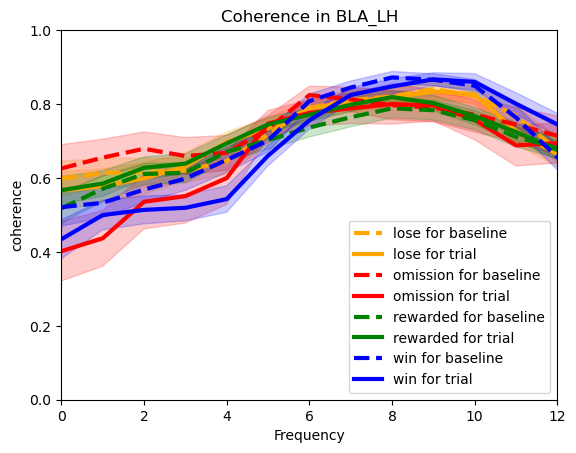

BLA_MD


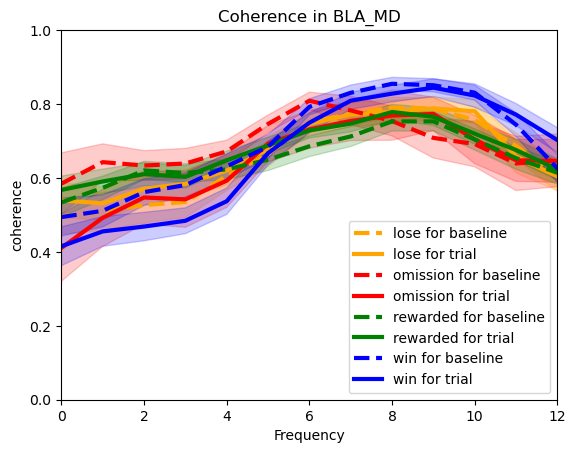

BLA_mPFC


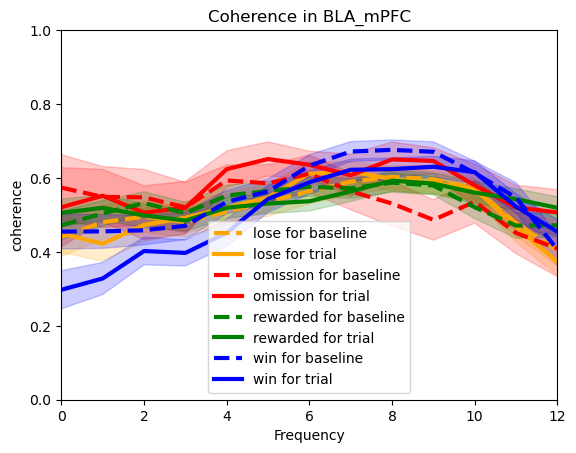

BLA_vHPC


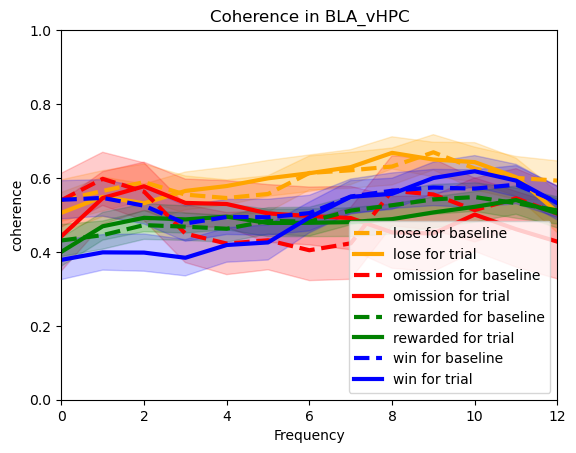

LH_MD


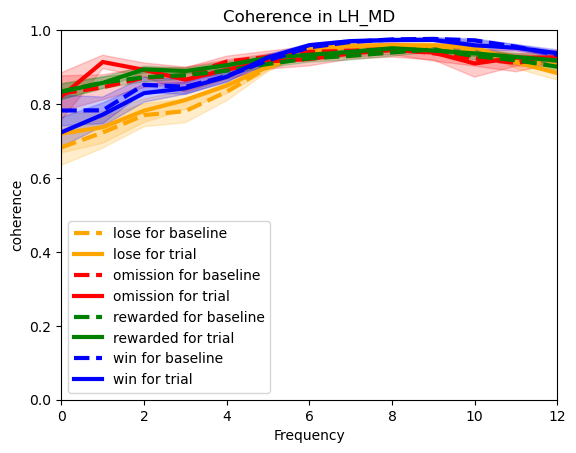

LH_mPFC


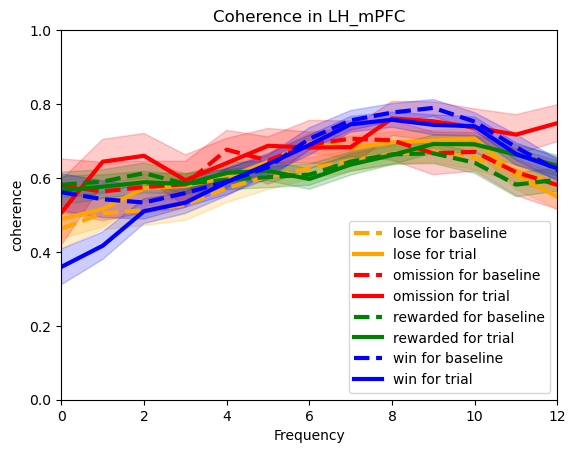

LH_vHPC


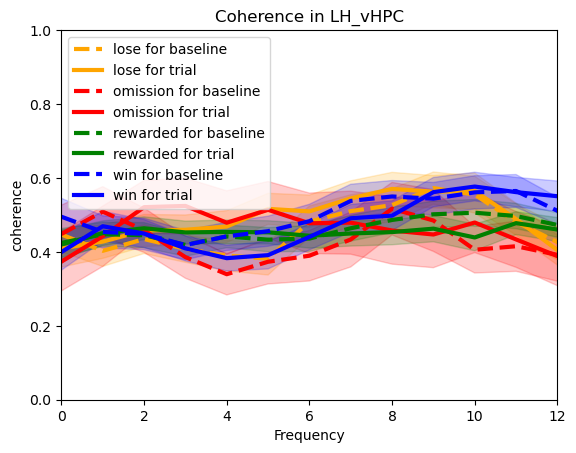

MD_mPFC


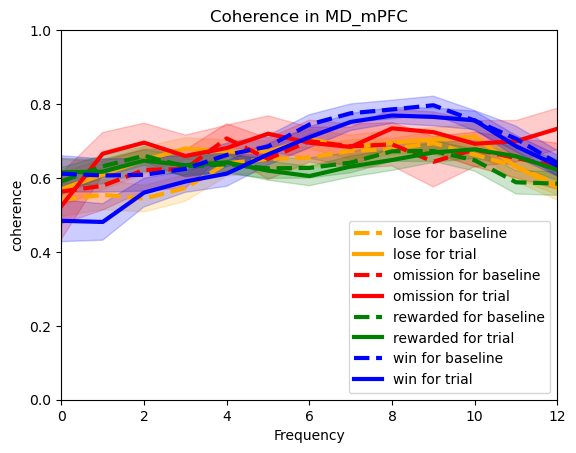

MD_vHPC


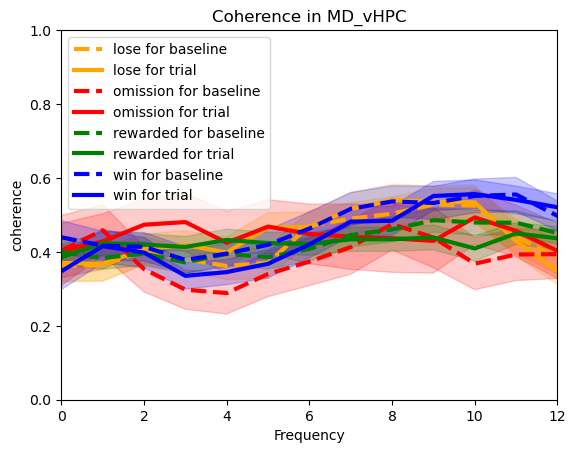

mPFC_vHPC


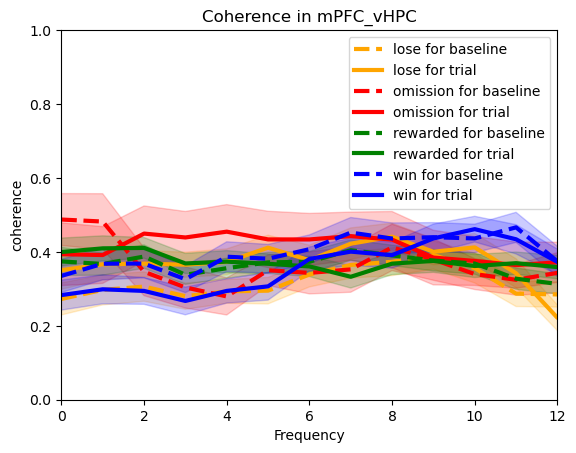

In [228]:
for pair_base_name in all_pair_base_name:
    print(pair_base_name)
    coherence_col = "{}_coherence_magnitude".format(pair_base_name)
    grouped_all_trials_df = channel_map_and_all_trials_df.groupby(['trial_outcome', 'trial_or_baseline']).agg({coherence_col: lambda x: np.vstack(x.tolist())}).reset_index()
    grouped_all_trials_df["mean_coherence"] = grouped_all_trials_df[coherence_col].apply(lambda x: np.nanmean(np.vstack(x), axis=0))
    grouped_all_trials_df["std_coherence"] = grouped_all_trials_df[coherence_col].apply(lambda x: np.nanstd(np.vstack(x), axis=0))
    grouped_all_trials_df["n_trials"] = grouped_all_trials_df[coherence_col].apply(lambda x: np.sum(~np.isnan(x), axis=0))
    grouped_all_trials_df["sem_coherence"] = grouped_all_trials_df.apply(lambda x: x["std_coherence"] / np.sqrt(x["n_trials"]), axis=1)
    fig, ax = plt.subplots()
    plt.title("Coherence in {}".format(pair_base_name))
    plt.xlabel("Frequency")
    plt.ylabel("coherence")
    plt.xlim(low_freq, high_freq)
    plt.ylim(0,1)

    for index, row in grouped_all_trials_df.iterrows():
        try:
            ax = sns.lineplot(x=all_frequencies, y=row["mean_coherence"], \
            label="{} for {}".format(row["trial_outcome"], \
            row["trial_or_baseline"]), color=BASELINE_OUTCOME_TO_COLOR[row["trial_outcome"]],
            linestyle=TRIAL_OR_BASELINE_TO_STYLE[row["trial_or_baseline"]], linewidth=3)

            plt.fill_between(all_frequencies, \
            row["mean_coherence"] - row["sem_coherence"], row["mean_coherence"] + row["sem_coherence"], alpha=0.2,
            color=BASELINE_OUTCOME_TO_COLOR[row["trial_outcome"]])
        except Exception as e: 
            print(e)
    plt.savefig("./proc/coherence/{}_coherence.png".format(pair_base_name))
    plt.show()
    
        
        # plt.savefig("./proc/velocity_parsing/plot_region_line_velocity_baselinetrial/\
        # rce_lfp_coherence_velocity_baselinetrial_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[-1]))
    

    

In [213]:
coherence_col = "{}_coherence_magnitude".format(pair_base_name)
grouped_all_trials_df = channel_map_and_all_trials_df.groupby(['trial_outcome', 'trial_or_baseline']).agg({coherence_col: lambda x: np.vstack(x.tolist())}).reset_index()

KeyError: 'Column(s) ["[\'BLA_LH\', \'BLA_MD\', \'BLA_mPFC\', \'BLA_vHPC\', \'LH_MD\', \'LH_mPFC\', \'LH_vHPC\', \'MD_mPFC\', \'MD_vHPC\', \'mPFC_vHPC\', \'BLA_LH\', \'BLA_MD\', \'BLA_mPFC\', \'BLA_vHPC\', \'LH_MD\', \'LH_mPFC\', \'LH_vHPC\', \'MD_mPFC\', \'MD_vHPC\', \'mPFC_vHPC\']_coherence_magnitude"] do not exist'

In [209]:
grouped_all_trials_df

NameError: name 'grouped_all_trials_df' is not defined

In [193]:
channel_map_and_all_trials_df.groupby(['trial_outcome', 'trial_or_baseline']).agg({coherence_col: lambda x: np.vstack(x.tolist())}).reset_index()

["coherence_BLA_LH"].iloc[0].shape

(74, 129)

In [69]:
grouped_all_trials_df = exploded_channel_map_and_all_trials_df.groupby(['brain_region', 'trial_or_baseline', 'binned_current_thorax_velocity']).agg({'power': lambda x: np.vstack(x.tolist())}).reset_index()

- Calculating the mean and sem of the LFP power

In [70]:
grouped_all_trials_df["mean_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanmean(np.vstack(x), axis=0))

In [71]:
grouped_all_trials_df["std_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanstd(np.vstack(x), axis=0))

In [72]:
grouped_all_trials_df["n_trials"] = grouped_all_trials_df["power"].apply(lambda x: np.sum(~np.isnan(x), axis=0))

In [73]:
grouped_all_trials_df["sem_power"] = grouped_all_trials_df.apply(lambda x: x["std_power"] / np.sqrt(x["n_trials"]), axis=1)

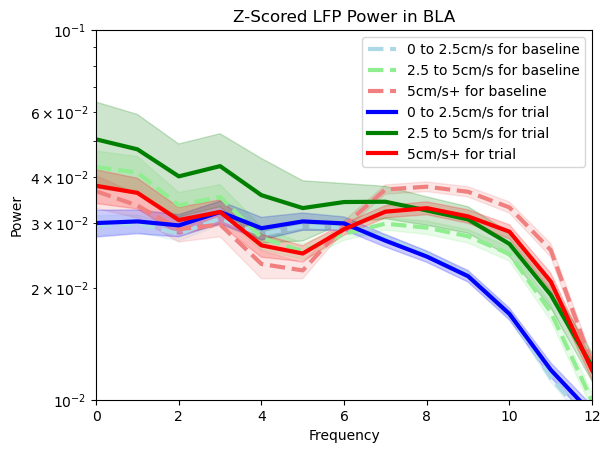

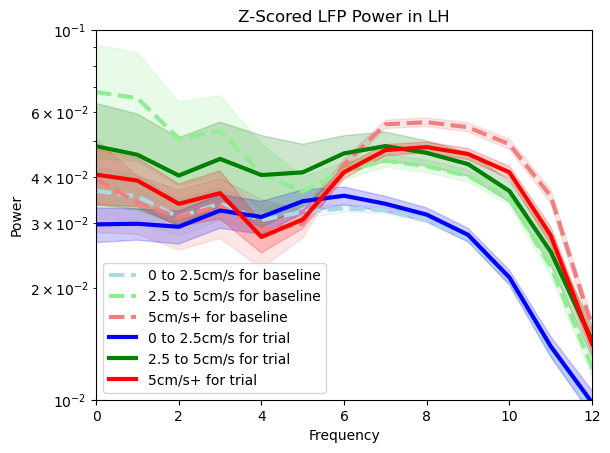

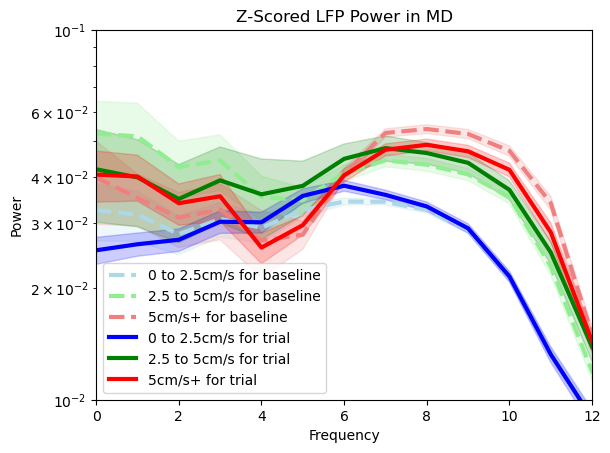

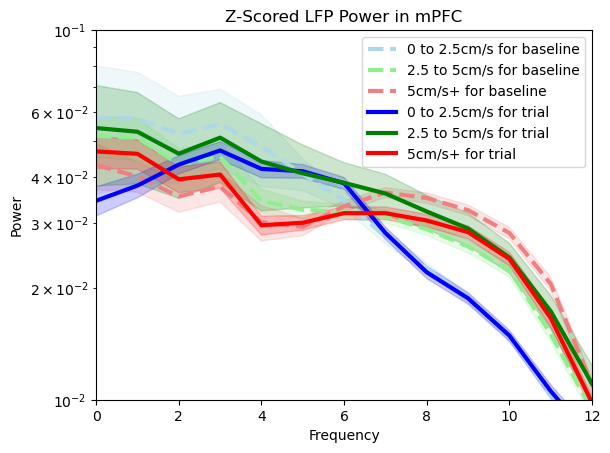

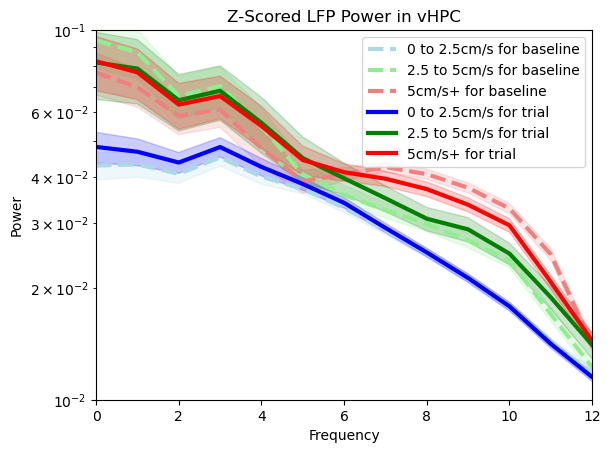

In [74]:
low_freq = 0
high_freq = 12
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]

    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {}".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq)    
    plt.yscale("log")
    plt.ylim(0.01, 0.1)

    for index, row in region_df.iterrows():
        try:
            ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], \
            label="{} for {}".format(BIN_TO_VELOCITY[row["binned_current_thorax_velocity"]], \
            row["trial_or_baseline"]), color=BIN_TO_COLOR[row["binned_current_thorax_velocity"]][row["trial_or_baseline"]],
            linestyle=TRIAL_OR_BASELINE_TO_STYLE[row["trial_or_baseline"]], linewidth=3)

            plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], \
            row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], alpha=0.2,
            color=BIN_TO_COLOR[row["binned_current_thorax_velocity"]][row["trial_or_baseline"]])
        except Exception as e: 
            print(e)
            continue

    plt.legend()
    
    plt.savefig("./proc/velocity_parsing/plot_region_line_velocity_baselinetrial/\
    rce_lfp_power_velocity_baselinetrial_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[-1]))


In [ ]:
for region_1, region_2 in brain_region_pairs:
    

(0.0, 50.0)

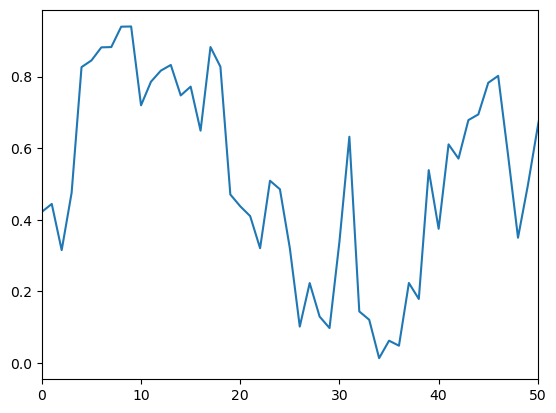

In [176]:
plt.plot(channel_map_and_all_trials_df["BLA_LH_frequencies"].iloc[0], channel_map_and_all_trials_df["BLA_LH_coherence_magnitude"].iloc[0])
plt.xlim(0,50)

(0.0, 50.0)

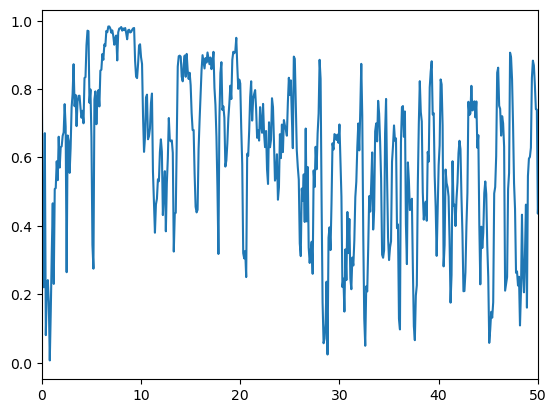

In [167]:
plt.plot(channel_map_and_all_trials_df["BLA_LH_frequencies"].iloc[0], channel_map_and_all_trials_df["BLA_LH_coherence_magnitude"].iloc[0])
plt.xlim(0,50)

In [164]:
channel_map_and_all_trials_df["BLA_LH_coherence_magnitude"].iloc[0][0, :, 0, 1].shape

(5000,)

In [ ]:
raise ValueError()

(0.0, 50.0)

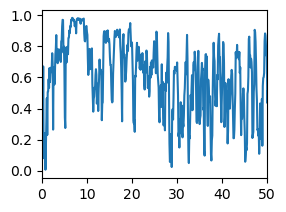

In [151]:
connectivity = Connectivity.from_multitaper(example_multi)
plt.subplot(2, 2, 3)
plt.plot(connectivity.frequencies, connectivity.coherence_magnitude()[0, :, 0, 1])
plt.xlim(0,50)

In [ ]:
exploded_channel_map_and_all_trials_df["multitaper"] = exploded_channel_map_and_all_trials_df["chunked_current_trace"].apply(lambda x: Multitaper(time_series=x,                                                                                        sampling_frequency=RESAMPLE_RATE))

In [ ]:
spectral_connectivity()

In [119]:
time_halfbandwidth_product = 2
frequency_of_interest = 200
sampling_frequency = 1500
time_extent = (0, 2.400)
n_trials = 100
n_signals = 4
n_time_samples = int(((time_extent[1] - time_extent[0]) * sampling_frequency) + 1)
time = np.linspace(time_extent[0], time_extent[1], num=n_time_samples, endpoint=True)

signal = np.zeros((n_time_samples, n_trials, n_signals))
signal[:, :, 0:2] = np.sin(2 * np.pi * time * frequency_of_interest)[
    :, np.newaxis, np.newaxis
] * np.ones((1, n_trials, 2))

other_signals = (n_signals + 1) // 2
n_other_signals = n_signals - other_signals
phase_offset = np.random.uniform(
    -np.pi, np.pi, size=(n_time_samples, n_trials, n_other_signals)
)
phase_offset[np.where(time > 1.5), :] = np.pi / 2
signal[:, :, other_signals:] = np.sin(
    (2 * np.pi * time[:, np.newaxis, np.newaxis] * frequency_of_interest) + phase_offset
)
noise = np.random.normal(0, 4, signal.shape)

In [ ]:
fmin = ...  # specify minimum frequency
fmax = ...  # specify maximum frequency
sfreq = ...  # specify sampling frequency

con, freqs, times, n_epochs, n_tapers = spectral_connectivity(
    data_stack, 
    method='coh', 
    mode='multitaper', 
    sfreq=sfreq, 
    fmin=fmin, 
    fmax=fmax, 
    faverage=True, 
    tmin=0, 
    mt_adaptive=False, 
    n_jobs=1
)

In [116]:
raise ValueError()

ValueError: 

In [53]:
melted_channel_map_and_all_trials_df["channel"] = melted_channel_map_and_all_trials_df["channel"].astype(int).astype(str)
melted_channel_map_and_all_trials_df["resampled_index"] = melted_channel_map_and_all_trials_df["resampled_index"].astype(int)

In [66]:
melted_channel_map_and_all_trials_df["trial_or_baseline_entire_lfp_index"] = melted_channel_map_and_all_trials_df["chunked_lfp_index"].apply(lambda x: (x[0][0], x[-1][-1]))

In [85]:
melted_channel_map_and_all_trials_df.columns

Index(['time', 'state', 'recording_dir', 'recording_file', 'din',
       'time_stamp_index', 'video_file', 'video_frame', 'video_number',
       'subject_info', 'condition', 'competition_closeness', 'Unnamed: 13',
       'resampled_index', 'all_subjects', 'current_subject', 'trial_outcome',
       'video_name', 'file_path', 'start_frame', 'stop_frame',
       'individual_subj', 'all_subj', 'recording_name', 'all_sleap_data',
       'locations', 'track_names', 'subject_to_index', 'subject_id',
       'subject_locations', 'corner_path', 'corner_parts', 'bottom_width',
       'top_width', 'right_height', 'left_height', 'average_height',
       'average_width', 'width_ratio', 'height_ratio', 'rescaled_locations',
       'box_top_left', 'box_bottom_right', 'box_bottom_left', 'box_top_right',
       'reward_port', 'all_thorax_locations', 'all_thorax_velocity',
       'trial_thorax_velocity', 'baseline_thorax_velocity',
       'trial_chunked_thorax_velocity', 'baseline_chunked_thorax_velocity

In [ ]:
melted_channel_map_and_all_trials_df["current_trace"] = melted_channel_map_and_all_trials_df.apply(lambda x: 
x["all_ch_lfp"].get_traces(channel_ids=[x["channel"]], start_frame=x["trial_or_baseline_entire_lfp_index"][0], end_frame=x["trial_or_baseline_entire_lfp_index"][-1] ), axis=1)

- Creating a new row for each brain region

In [47]:
brain_region_col = [col for col in CHANNEL_MAPPING_DF if "spike_interface" in col]

In [48]:
id_cols = [col for col in channel_map_and_all_trials_df.columns if col not in brain_region_col]

In [49]:
melted_channel_map_and_all_trials_df = channel_map_and_all_trials_df.melt(id_vars=id_cols ,value_vars=brain_region_col, var_name='brain_region', value_name='channel')


In [51]:
melted_channel_map_and_all_trials_df.head()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,...,Cohort,Subject,eib_mPFC,eib_vHPC,eib_BLA,eib_LH,eib_MD,all_ch_lfp,brain_region,channel
0,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,2,1.1,NaN,16,17,18,19,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_mPFC,5.0
1,1934930,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,20230618_100636_standard_comp_to_omission_D2_s...,1097,1,1_1_t1b2L_box2,...,2,1.1,NaN,16,17,18,19,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_mPFC,5.0
2,4334936,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,3499256,20230618_100636_standard_comp_to_omission_D2_s...,3492,1,1_1_t1b2L_box2,...,2,1.1,NaN,16,17,18,19,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_mPFC,5.0
3,4334936,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,3499256,20230618_100636_standard_comp_to_omission_D2_s...,3492,1,1_1_t1b2L_box2,...,2,1.1,NaN,16,17,18,19,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_mPFC,5.0
4,6634931,1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,5799251,20230618_100636_standard_comp_to_omission_D2_s...,5788,1,1_1_t1b2L_box2,...,2,1.1,NaN,16,17,18,19,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_mPFC,5.0


In [52]:
melted_channel_map_and_all_trials_df.tail()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,...,Cohort,Subject,eib_mPFC,eib_vHPC,eib_BLA,eib_LH,eib_MD,all_ch_lfp,brain_region,channel
1515,66660918,1,20230620_114347_standard_comp_to_omission_D4_s...,20230620_114347_standard_comp_to_omission_D4_s...,dio_ECU_Din1,64158037,20230620_114347_standard_comp_to_omission_D4_s...,64089,1,1-2_t3b3L_box_1,...,2,1.2,NaN,31,30,29,28,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_MD,28.0
1516,68560944,1,20230620_114347_standard_comp_to_omission_D4_s...,20230620_114347_standard_comp_to_omission_D4_s...,dio_ECU_Din1,66058063,20230620_114347_standard_comp_to_omission_D4_s...,65986,1,1-2_t3b3L_box_1,...,2,1.2,NaN,31,30,29,28,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_MD,28.0
1517,68560944,1,20230620_114347_standard_comp_to_omission_D4_s...,20230620_114347_standard_comp_to_omission_D4_s...,dio_ECU_Din1,66058063,20230620_114347_standard_comp_to_omission_D4_s...,65986,1,1-2_t3b3L_box_1,...,2,1.2,NaN,31,30,29,28,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_MD,28.0
1518,69560954,1,20230620_114347_standard_comp_to_omission_D4_s...,20230620_114347_standard_comp_to_omission_D4_s...,dio_ECU_Din1,67058073,20230620_114347_standard_comp_to_omission_D4_s...,66984,1,1-2_t3b3L_box_1,...,2,1.2,NaN,31,30,29,28,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_MD,28.0
1519,69560954,1,20230620_114347_standard_comp_to_omission_D4_s...,20230620_114347_standard_comp_to_omission_D4_s...,dio_ECU_Din1,67058073,20230620_114347_standard_comp_to_omission_D4_s...,66984,1,1-2_t3b3L_box_1,...,2,1.2,NaN,31,30,29,28,ZScoreRecording: 32 channels - 1 segments - 1....,spike_interface_MD,28.0


- Getting the traces for each trial for each brain region

In [53]:
melted_channel_map_and_all_trials_df["channel"] = melted_channel_map_and_all_trials_df["channel"].astype(int).astype(str)
melted_channel_map_and_all_trials_df["resampled_index"] = melted_channel_map_and_all_trials_df["resampled_index"].astype(int)

In [66]:
melted_channel_map_and_all_trials_df["trial_or_baseline_entire_lfp_index"] = melted_channel_map_and_all_trials_df["chunked_lfp_index"].apply(lambda x: (x[0][0], x[-1][-1]))

In [67]:
melted_channel_map_and_all_trials_df["trial_or_baseline_entire_lfp_index"]

0           (44962, 54962)
1           (54962, 64962)
2         (164962, 174962)
3         (174962, 184962)
4         (279962, 289962)
               ...        
1515    (3207901, 3217901)
1516    (3292903, 3302903)
1517    (3302903, 3312903)
1518    (3342903, 3352903)
1519    (3352903, 3362903)
Name: trial_or_baseline_entire_lfp_index, Length: 1520, dtype: object

In [72]:
melted_channel_map_and_all_trials_df["current_trace"] = melted_channel_map_and_all_trials_df.apply(lambda x: 
x["all_ch_lfp"].get_traces(channel_ids=[x["channel"]], start_frame=x["trial_or_baseline_entire_lfp_index"][0], end_frame=x["trial_or_baseline_entire_lfp_index"][-1] ), axis=1)

In [73]:
melted_channel_map_and_all_trials_df.columns

Index(['time', 'state', 'recording_dir', 'recording_file', 'din',
       'time_stamp_index', 'video_file', 'video_frame', 'video_number',
       'subject_info', 'condition', 'competition_closeness', 'Unnamed: 13',
       'resampled_index', 'all_subjects', 'current_subject', 'trial_outcome',
       'video_name', 'file_path', 'start_frame', 'stop_frame',
       'individual_subj', 'all_subj', 'recording_name', 'all_sleap_data',
       'locations', 'track_names', 'subject_to_index', 'subject_id',
       'subject_locations', 'corner_path', 'corner_parts', 'bottom_width',
       'top_width', 'right_height', 'left_height', 'average_height',
       'average_width', 'width_ratio', 'height_ratio', 'rescaled_locations',
       'box_top_left', 'box_bottom_right', 'box_bottom_left', 'box_top_right',
       'reward_port', 'all_thorax_locations', 'all_thorax_velocity',
       'trial_thorax_velocity', 'baseline_thorax_velocity',
       'trial_chunked_thorax_velocity', 'baseline_chunked_thorax_velocity

In [76]:
melted_channel_map_and_all_trials_df["recording_file"].iloc[0]

'20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged'

In [77]:
melted_channel_map_and_all_trials_df["subject_id"].iloc[0]

'1.1'

In [ ]:
# Step 2: Define the columns where values should be shared between pairs
shared_columns = ['Column1', 'Column2']

# Step 3: Find all unique values in the shared columns
unique_values = {col: df[col].unique() for col in shared_columns}

In [ ]:
melted_channel_map_and_all_trials_df["chunked_current_trace"] = melted_channel_map_and_all_trials_df.apply(lambda x: 
[x["all_ch_lfp"].get_traces(channel_ids=[x["channel"]], start_frame=chunk_index[0], end_frame=chunk_index[1]).T[0] for chunk_index in x["chunked_lfp_index"]], axis=1)

In [ ]:
len(melted_channel_map_and_all_trials_df["chunked_current_trace"].iloc[0])

In [ ]:
melted_channel_map_and_all_trials_df["chunked_current_trace"]

In [ ]:
exploded_channel_map_and_all_trials_df = melted_channel_map_and_all_trials_df.explode(["current_chunked_thorax_velocity", "chunked_current_trace", "binned_current_thorax_velocity", "chunked_lfp_index",	"chunked_ephys_timestamp"])

In [ ]:
exploded_channel_map_and_all_trials_df

In [ ]:
exploded_channel_map_and_all_trials_df["len_chunked_current_trace"] = exploded_channel_map_and_all_trials_df["chunked_current_trace"].apply(lambda x: len(x))


In [ ]:
exploded_channel_map_and_all_trials_df["len_chunked_current_trace"].unique()

In [ ]:
exploded_channel_map_and_all_trials_df["chunked_current_trace"] = exploded_channel_map_and_all_trials_df["chunked_current_trace"].apply(lambda x: x[:RESAMPLE_RATE])

In [ ]:
exploded_channel_map_and_all_trials_df["chunked_current_trace"]

- Calcuating the power at each frequency band

In [ ]:
exploded_channel_map_and_all_trials_df["multitaper"] = exploded_channel_map_and_all_trials_df["chunked_current_trace"].apply(lambda x: Multitaper(time_series=x,                                                                                        sampling_frequency=RESAMPLE_RATE))

In [ ]:
exploded_channel_map_and_all_trials_df["connectivity"] = exploded_channel_map_and_all_trials_df["multitaper"].apply(lambda x: Connectivity.from_multitaper(x))

In [ ]:
exploded_channel_map_and_all_trials_df["frequencies"] = exploded_channel_map_and_all_trials_df["connectivity"].apply(lambda x: x.frequencies)

In [ ]:
exploded_channel_map_and_all_trials_df["power"] = exploded_channel_map_and_all_trials_df["connectivity"].apply(lambda x: x.power().squeeze())

In [ ]:
exploded_channel_map_and_all_trials_df.head()

In [ ]:
exploded_channel_map_and_all_trials_df.tail()

# Plotting by velocity

- Grouping all the rows(1s segment of trials) that share the same brain region, whether its before or after the tone, and velocity grouping

In [ ]:
grouped_all_trials_df = exploded_channel_map_and_all_trials_df.groupby(['brain_region', 'trial_or_baseline', 'binned_current_thorax_velocity']).agg({'power': lambda x: np.vstack(x.tolist())}).reset_index()

- Calculating the mean and sem of the LFP power

In [ ]:
grouped_all_trials_df["mean_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanmean(np.vstack(x), axis=0))

In [ ]:
grouped_all_trials_df["std_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanstd(np.vstack(x), axis=0))

In [ ]:
grouped_all_trials_df["n_trials"] = grouped_all_trials_df["power"].apply(lambda x: np.sum(~np.isnan(x), axis=0))

In [ ]:
grouped_all_trials_df["sem_power"] = grouped_all_trials_df.apply(lambda x: x["std_power"] / np.sqrt(x["n_trials"]), axis=1)

In [ ]:
low_freq = 0
high_freq = 12
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]

    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {}".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq)    
    plt.yscale("log")
    plt.ylim(0.01, 0.1)

    for index, row in region_df.iterrows():
        try:
            ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], \
            label="{} for {}".format(BIN_TO_VELOCITY[row["binned_current_thorax_velocity"]], \
            row["trial_or_baseline"]), color=BIN_TO_COLOR[row["binned_current_thorax_velocity"]][row["trial_or_baseline"]],
            linestyle=TRIAL_OR_BASELINE_TO_STYLE[row["trial_or_baseline"]], linewidth=3)

            plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], \
            row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], alpha=0.2,
            color=BIN_TO_COLOR[row["binned_current_thorax_velocity"]][row["trial_or_baseline"]])
        except Exception as e: 
            print(e)
            continue

    plt.legend()
    
    plt.savefig("./proc/velocity_parsing/plot_region_line_velocity_baselinetrial/\
    rce_lfp_power_velocity_baselinetrial_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[-1]))


In [ ]:
low_freq = 12
high_freq = 30
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]

    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {}".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq)    
    plt.yscale("log")
    plt.ylim(0.002, 0.015) 

    for index, row in region_df.iterrows():
        try:
            ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], \
            label="{} for {}".format(BIN_TO_VELOCITY[row["binned_current_thorax_velocity"]], \
            row["trial_or_baseline"]), color=BIN_TO_COLOR[row["binned_current_thorax_velocity"]][row["trial_or_baseline"]],
            linestyle=TRIAL_OR_BASELINE_TO_STYLE[row["trial_or_baseline"]], linewidth=3)

            plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], \
            row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], alpha=0.2,
            color=BIN_TO_COLOR[row["binned_current_thorax_velocity"]][row["trial_or_baseline"]])
        except Exception as e: 
            print(e)
            continue

    plt.savefig("./proc/velocity_parsing/plot_region_line_velocity_baselinetrial/\
    rce_lfp_power_velocity_baselinetrial_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[-1]))


In [ ]:
low_freq = 30
high_freq = 90
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]

    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {}".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq)    
    # plt.ylim(0, 0.005)
    plt.yscale("log")
    plt.ylim(0.0003, 0.005) 

    for index, row in region_df.iterrows():
        try:
            ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], \
            label="{} for {}".format(BIN_TO_VELOCITY[row["binned_current_thorax_velocity"]], \
            row["trial_or_baseline"]), color=BIN_TO_COLOR[row["binned_current_thorax_velocity"]][row["trial_or_baseline"]],
            linestyle=TRIAL_OR_BASELINE_TO_STYLE[row["trial_or_baseline"]], linewidth=3)

            plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], \
            row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], alpha=0.2,
            color=BIN_TO_COLOR[row["binned_current_thorax_velocity"]][row["trial_or_baseline"]])
        except Exception as e: 
            print(e)
            continue
    plt.legend()
    plt.savefig("./proc/velocity_parsing/plot_region_line_velocity_baselinetrial/\
    rce_lfp_power_velocity_baselinetrial_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[-1]))


## Plotting all the lower velocities together

In [ ]:
speed_filtered_all_trials_df = exploded_channel_map_and_all_trials_df[exploded_channel_map_and_all_trials_df["binned_current_thorax_velocity"] <= 1]

In [ ]:
speed_filtered_all_trials_df.shape

In [ ]:
grouped_all_trials_df = speed_filtered_all_trials_df.groupby(['brain_region', 'trial_outcome', 'trial_or_baseline']).agg({'power': lambda x: np.vstack(x.tolist())}).reset_index()

In [ ]:
grouped_all_trials_df["mean_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanmean(np.vstack(x), axis=0))

In [ ]:
grouped_all_trials_df["std_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanstd(np.vstack(x), axis=0))

In [ ]:
grouped_all_trials_df["n_trials"] = grouped_all_trials_df["power"].apply(lambda x: np.sum(~np.isnan(x), axis=0))

In [ ]:
grouped_all_trials_df["sem_power"] = grouped_all_trials_df.apply(lambda x: x["std_power"] / np.sqrt(x["n_trials"]), axis=1)

In [ ]:
grouped_all_trials_df["trial_outcome"].unique()

# Drawing plots all together

In [ ]:
low_freq = 0
high_freq = 12
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    
    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {} at 0 to 5cm/s".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq) 
    # plt.yscale("log")
    # plt.ylim(0.01, 0.06)

    for trial_or_baseline, outcome in itertools.product(region_df["trial_or_baseline"].unique(), sorted(region_df["trial_outcome"].unique())[::-1]):
        outcome_df = region_df[(region_df["trial_or_baseline"] == trial_or_baseline) & (region_df["trial_outcome"] == outcome)]
        for index, row in outcome_df.iterrows():
            try:
                ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], \
                label="{} {}".format(outcome, trial_or_baseline), color=BASELINE_OUTCOME_TO_COLOR[outcome], \
                linestyle=TRIAL_OR_BASELINE_TO_STYLE[trial_or_baseline], linewidth=3)
                
                plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], 
                row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], \
                alpha=0.1, color=BASELINE_OUTCOME_TO_COLOR[outcome])
            
            except Exception as e: 
                print(e)
                continue
    plt.legend(loc="upper left")
    plt.savefig("./proc/velocity_parsing/plot_region_line_trialoutcome_baselinetrial/\
    rce_lower_velocity_lfp_power_trialoutcome_baselinetrial_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[-1]))

In [ ]:
low_freq = 12
high_freq = 30
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    
    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {} at 0 to 5cm/s".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq)    
    plt.yscale("log")
    plt.ylim(0.002, 0.015) 
    
    for trial_or_baseline, outcome in itertools.product(region_df["trial_or_baseline"].unique(), sorted(region_df["trial_outcome"].unique())[::-1]):
        outcome_df = region_df[(region_df["trial_or_baseline"] == trial_or_baseline) & (region_df["trial_outcome"] == outcome)]
        for index, row in outcome_df.iterrows():
            try:
                ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], \
                label="{} {}".format(outcome, trial_or_baseline), color=BASELINE_OUTCOME_TO_COLOR[outcome], \
                linestyle=TRIAL_OR_BASELINE_TO_STYLE[trial_or_baseline], linewidth=3)
                
                plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], 
                row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], \
                alpha=0.1, color=BASELINE_OUTCOME_TO_COLOR[outcome])
            
            except Exception as e: 
                print(e)
                continue
    plt.legend()
    plt.savefig("./proc/velocity_parsing/plot_region_line_trialoutcome_baselinetrial/\
    rce_lower_velocity_lfp_power_trialoutcome_baselinetrial_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[-1]))

In [ ]:
low_freq = 30
high_freq = 90
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    
    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {} at 0 to 5cm/s".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq)    
    plt.yscale("log")
    plt.ylim(0.0003, 0.005) 
    
    for trial_or_baseline, outcome in itertools.product(region_df["trial_or_baseline"].unique(), sorted(region_df["trial_outcome"].unique())[::-1]):
        outcome_df = region_df[(region_df["trial_or_baseline"] == trial_or_baseline) & (region_df["trial_outcome"] == outcome)]
        for index, row in outcome_df.iterrows():
            try:
                ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], \
                label="{} {}".format(outcome, trial_or_baseline), color=BASELINE_OUTCOME_TO_COLOR[outcome], \
                linestyle=TRIAL_OR_BASELINE_TO_STYLE[trial_or_baseline], linewidth=3)
                
                plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], 
                row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], \
                alpha=0.2, color=BASELINE_OUTCOME_TO_COLOR[outcome])
            
            except Exception as e: 
                print(e)
                continue
    plt.legend()
    plt.savefig("./proc/velocity_parsing/plot_region_line_trialoutcome_baselinetrial/\
    rce_lower_velocity_lfp_power_trialoutcome_baselinetrial_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[-1]))

## Plotting all the higher velocities together

In [ ]:
speed_filtered_all_trials_df = exploded_channel_map_and_all_trials_df[exploded_channel_map_and_all_trials_df["binned_current_thorax_velocity"] >= 2]

In [ ]:
grouped_all_trials_df = speed_filtered_all_trials_df.groupby(['brain_region', 'trial_outcome', 'trial_or_baseline']).agg({'power': lambda x: np.vstack(x.tolist())}).reset_index()

In [ ]:
grouped_all_trials_df["mean_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanmean(np.vstack(x), axis=0))

In [ ]:
grouped_all_trials_df["std_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanstd(np.vstack(x), axis=0))

In [ ]:
grouped_all_trials_df["n_trials"] = grouped_all_trials_df["power"].apply(lambda x: np.sum(~np.isnan(x), axis=0))

In [ ]:
grouped_all_trials_df["sem_power"] = grouped_all_trials_df.apply(lambda x: x["std_power"] / np.sqrt(x["n_trials"]), axis=1)

# Drawing plots all together

In [ ]:
low_freq = 0
high_freq = 12
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    
    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {} at 5 cm/s+".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq)   
    plt.yscale("log")
    plt.ylim(0.01, 0.1)

    for trial_or_baseline, outcome in itertools.product(region_df["trial_or_baseline"].unique(), sorted(region_df["trial_outcome"].unique())[::-1]):
        outcome_df = region_df[(region_df["trial_or_baseline"] == trial_or_baseline) & (region_df["trial_outcome"] == outcome)]
        for index, row in outcome_df.iterrows():
            try:
                ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], \
                label="{} {}".format(outcome, trial_or_baseline), color=BASELINE_OUTCOME_TO_COLOR[outcome], \
                linestyle=TRIAL_OR_BASELINE_TO_STYLE[trial_or_baseline], linewidth=3)
                
                plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], 
                row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], \
                alpha=0.2, color=BASELINE_OUTCOME_TO_COLOR[outcome])
            
            except Exception as e: 
                print(e)
                continue
    plt.legend()
    plt.savefig("./proc/velocity_parsing/plot_region_line_trialoutcome_baselinetrial/\
    rce_higher_velocity_lfp_power_trialoutcome_baselinetrial_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[-1]))

In [ ]:
low_freq = 12
high_freq = 30
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    
    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {} at 5 cm/s+".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq)    
    plt.yscale("log")
    plt.ylim(0.002, 0.015) 
    
    for trial_or_baseline, outcome in itertools.product(region_df["trial_or_baseline"].unique(), sorted(region_df["trial_outcome"].unique())[::-1]):
        outcome_df = region_df[(region_df["trial_or_baseline"] == trial_or_baseline) & (region_df["trial_outcome"] == outcome)]
        for index, row in outcome_df.iterrows():
            try:
                ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], \
                label="{} {}".format(outcome, trial_or_baseline), color=BASELINE_OUTCOME_TO_COLOR[outcome], \
                linestyle=TRIAL_OR_BASELINE_TO_STYLE[trial_or_baseline], linewidth=3)
                
                plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], 
                row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], \
                alpha=0.2, color=BASELINE_OUTCOME_TO_COLOR[outcome])
            
            except Exception as e: 
                print(e)
                continue
    plt.legend()
    plt.savefig("./proc/velocity_parsing/plot_region_line_trialoutcome_baselinetrial/\
    rce_higher_velocity_lfp_power_trialoutcome_baselinetrial_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[-1]))

In [ ]:
low_freq = 30
high_freq = 90
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    
    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {} at 5 cm/s+".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq)    
    plt.yscale("log")
    plt.ylim(0.0003, 0.005) 
    
    for trial_or_baseline, outcome in itertools.product(region_df["trial_or_baseline"].unique(), sorted(region_df["trial_outcome"].unique())[::-1]):
        outcome_df = region_df[(region_df["trial_or_baseline"] == trial_or_baseline) & (region_df["trial_outcome"] == outcome)]
        for index, row in outcome_df.iterrows():
            try:
                ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], \
                label="{} {}".format(outcome, trial_or_baseline), color=BASELINE_OUTCOME_TO_COLOR[outcome], \
                linestyle=TRIAL_OR_BASELINE_TO_STYLE[trial_or_baseline], linewidth=3)
                
                plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], 
                row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], \
                alpha=0.2, color=BASELINE_OUTCOME_TO_COLOR[outcome])
            
            except Exception as e: 
                print(e)
                continue
    plt.legend()
    plt.savefig("./proc/velocity_parsing/plot_region_line_trialoutcome_baselinetrial/\
    rce_higher_velocity_lfp_power_trialoutcome_baselinetrial_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[-1]))

## Plotting all the competitiveness and lower velocities together

In [ ]:
speed_filtered_all_trials_df = exploded_channel_map_and_all_trials_df[exploded_channel_map_and_all_trials_df["binned_current_thorax_velocity"] <= 1]

In [ ]:
speed_filtered_all_trials_df.shape

In [ ]:
grouped_all_trials_df = speed_filtered_all_trials_df.groupby(['brain_region', 'competition_closeness', 'trial_or_baseline']).agg({'power': lambda x: np.vstack(x.tolist())}).reset_index()

In [ ]:
grouped_all_trials_df["mean_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanmean(np.vstack(x), axis=0))

In [ ]:
grouped_all_trials_df["std_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanstd(np.vstack(x), axis=0))

In [ ]:
grouped_all_trials_df["n_trials"] = grouped_all_trials_df["power"].apply(lambda x: np.sum(~np.isnan(x), axis=0))

In [ ]:
grouped_all_trials_df["sem_power"] = grouped_all_trials_df.apply(lambda x: x["std_power"] / np.sqrt(x["n_trials"]), axis=1)

In [ ]:
grouped_all_trials_df["competition_closeness"].unique()

# Drawing plots all together

In [ ]:
region_df

In [ ]:
low_freq = 0
high_freq = 12
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    
    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {} at 0 to 5cm/s".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq)  
    plt.yscale("log")
    plt.ylim(0.01, 0.1) 


    for index, row in region_df.iterrows():
        try:
            ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], \
            label="{} {}".format(row["competition_closeness"], row["trial_or_baseline"]), color=COMPETITIVE_OUTCOME_TO_COLOR[row["competition_closeness"]], \
            linestyle=TRIAL_OR_BASELINE_TO_STYLE[row["trial_or_baseline"]], linewidth=3)
            
            plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], 
            row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], \
            alpha=0.1, color=COMPETITIVE_OUTCOME_TO_COLOR[row["competition_closeness"]])
        
        except Exception as e: 
            print(e)
            continue
    
    # Create a legend outside of the plot
    legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Save the plot along with the legend outside of it   
    plt.savefig("./proc/velocity_parsing/plot_region_line_competitioncloseness_baselinetrial/\
    rce_lower_velocity_lfp_power_competitioncloseness_baselinetrial_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[-1]), bbox_extra_artists=(legend,), bbox_inches='tight')

    # Display the plot
    plt.show()


In [ ]:
low_freq = 12
high_freq = 30
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    
    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {} at 0 to 5cm/s".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq)    
    plt.yscale("log")
    plt.ylim(0.002, 0.015) 

    for index, row in region_df.iterrows():
        try:
            ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], \
            label="{} {}".format(row["competition_closeness"], row["trial_or_baseline"]), color=COMPETITIVE_OUTCOME_TO_COLOR[row["competition_closeness"]], \
            linestyle=TRIAL_OR_BASELINE_TO_STYLE[row["trial_or_baseline"]], linewidth=3)
            
            plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], 
            row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], \
            alpha=0.1, color=COMPETITIVE_OUTCOME_TO_COLOR[row["competition_closeness"]])
        
        except Exception as e: 
            print(e)
            continue
            
    # Create a legend outside of the plot
    legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Save the plot along with the legend outside of it   
    plt.savefig("./proc/velocity_parsing/plot_region_line_competitioncloseness_baselinetrial/\
    rce_lower_velocity_lfp_power_competitioncloseness_baselinetrial_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[-1]), bbox_extra_artists=(legend,), bbox_inches='tight')

    # Display the plot
    plt.show()

In [ ]:
low_freq = 30
high_freq = 90
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    
    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {} at 0 to 5cm/s".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq)    
    plt.yscale("log")
    plt.ylim(0.0003, 0.005) 

    for index, row in region_df.iterrows():
        try:
            ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], \
            label="{} {}".format(row["competition_closeness"], row["trial_or_baseline"]), color=COMPETITIVE_OUTCOME_TO_COLOR[row["competition_closeness"]], \
            linestyle=TRIAL_OR_BASELINE_TO_STYLE[row["trial_or_baseline"]], linewidth=3)
            
            plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], 
            row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], \
            alpha=0.1, color=COMPETITIVE_OUTCOME_TO_COLOR[row["competition_closeness"]])
        
        except Exception as e: 
            print(e)
            continue
    # Create a legend outside of the plot
    legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Save the plot along with the legend outside of it   
    plt.savefig("./proc/velocity_parsing/plot_region_line_competitioncloseness_baselinetrial/\
    rce_lower_velocity_lfp_power_competitioncloseness_baselinetrial_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[-1]), bbox_extra_artists=(legend,), bbox_inches='tight')

    # Display the plot
    plt.show()

## Plotting all the higher velocities together

In [ ]:
speed_filtered_all_trials_df = exploded_channel_map_and_all_trials_df[exploded_channel_map_and_all_trials_df["binned_current_thorax_velocity"] >= 2]

In [ ]:
grouped_all_trials_df = speed_filtered_all_trials_df.groupby(['brain_region', 'competition_closeness', 'trial_or_baseline']).agg({'power': lambda x: np.vstack(x.tolist())}).reset_index()

In [ ]:
grouped_all_trials_df["mean_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanmean(np.vstack(x), axis=0))

In [ ]:
grouped_all_trials_df["std_power"] = grouped_all_trials_df["power"].apply(lambda x: np.nanstd(np.vstack(x), axis=0))

In [ ]:
grouped_all_trials_df["n_trials"] = grouped_all_trials_df["power"].apply(lambda x: np.sum(~np.isnan(x), axis=0))

In [ ]:
grouped_all_trials_df["sem_power"] = grouped_all_trials_df.apply(lambda x: x["std_power"] / np.sqrt(x["n_trials"]), axis=1)

# Drawing plots all together

In [ ]:
low_freq = 0
high_freq = 12
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    
    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {} at 5cm/s+".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq)    
    plt.yscale("log")
    plt.ylim(0.01, 0.1) 

    for index, row in region_df.iterrows():
        try:
            ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], \
            label="{} {}".format(row["competition_closeness"], row["trial_or_baseline"]), color=COMPETITIVE_OUTCOME_TO_COLOR[row["competition_closeness"]], \
            linestyle=TRIAL_OR_BASELINE_TO_STYLE[row["trial_or_baseline"]], linewidth=3)
            
            plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], 
            row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], \
            alpha=0.1, color=COMPETITIVE_OUTCOME_TO_COLOR[row["competition_closeness"]])
        
        except Exception as e: 
            print(e)
            continue
    # Create a legend outside of the plot
    legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Save the plot along with the legend outside of it   
    plt.savefig("./proc/velocity_parsing/plot_region_line_competitioncloseness_baselinetrial/\
    rce_higher_velocity_lfp_power_competitioncloseness_baselinetrial_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[-1]), bbox_extra_artists=(legend,), bbox_inches='tight')

    # Display the plot
    plt.show()

In [ ]:
low_freq = 12
high_freq = 30
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    
    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {} at 5cm/s+".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq)    
    plt.yscale("log")
    plt.ylim(0.002, 0.015) 

    
    for index, row in region_df.iterrows():
        try:
            ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], \
            label="{} {}".format(row["competition_closeness"], row["trial_or_baseline"]), color=COMPETITIVE_OUTCOME_TO_COLOR[row["competition_closeness"]], \
            linestyle=TRIAL_OR_BASELINE_TO_STYLE[row["trial_or_baseline"]], linewidth=3)
            
            plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], 
            row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], \
            alpha=0.1, color=COMPETITIVE_OUTCOME_TO_COLOR[row["competition_closeness"]])
        
        except Exception as e: 
            print(e)
            continue
    # Create a legend outside of the plot
    legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Save the plot along with the legend outside of it   
    plt.savefig("./proc/velocity_parsing/plot_region_line_competitioncloseness_baselinetrial/\
    rce_higher_velocity_lfp_power_competitioncloseness_baselinetrial_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[-1]), bbox_extra_artists=(legend,), bbox_inches='tight')

    # Display the plot
    plt.show()

In [ ]:
low_freq = 12
high_freq = 30
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    
    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {} at 5cm/s+".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq)    
    plt.yscale("log")
    plt.ylim(0.002, 0.015) 
    
    for index, row in region_df.iterrows():
        try:
            ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], \
            label="{} {}".format(row["competition_closeness"], row["trial_or_baseline"]), color=COMPETITIVE_OUTCOME_TO_COLOR[row["competition_closeness"]], \
            linestyle=TRIAL_OR_BASELINE_TO_STYLE[row["trial_or_baseline"]], linewidth=3)
            
            plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], 
            row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], \
            alpha=0.1, color=COMPETITIVE_OUTCOME_TO_COLOR[row["competition_closeness"]])
        
        except Exception as e: 
            print(e)
            continue
    # Create a legend outside of the plot
    legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Save the plot along with the legend outside of it   
    plt.savefig("./proc/velocity_parsing/plot_region_line_competitioncloseness_baselinetrial/\
    rce_higher_velocity_lfp_power_competitioncloseness_baselinetrial_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[-1]), bbox_extra_artists=(legend,), bbox_inches='tight')

    # Display the plot
    plt.show()

In [ ]:
low_freq = 30
high_freq = 90
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    
    fig, ax = plt.subplots()
    plt.title("Z-Scored LFP Power in {} at 5cm/s+".format(region.split("_")[-1]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(low_freq, high_freq)    
    plt.yscale("log")
    plt.ylim(0.0003, 0.005) 
    
    for index, row in region_df.iterrows():
        try:
            ax = sns.lineplot(x=exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], \
            label="{} {}".format(row["competition_closeness"], row["trial_or_baseline"]), color=COMPETITIVE_OUTCOME_TO_COLOR[row["competition_closeness"]], \
            linestyle=TRIAL_OR_BASELINE_TO_STYLE[row["trial_or_baseline"]], linewidth=3)
            
            plt.fill_between(exploded_channel_map_and_all_trials_df["frequencies"].iloc[0], 
            row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], \
            alpha=0.1, color=COMPETITIVE_OUTCOME_TO_COLOR[row["competition_closeness"]])
        
        except Exception as e: 
            print(e)
            continue
            
    # Create a legend outside of the plot
    legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Save the plot along with the legend outside of it   
    plt.savefig("./proc/velocity_parsing/plot_region_line_competitioncloseness_baselinetrial/\
    rce_higher_velocity_lfp_power_competitioncloseness_baselinetrial_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[-1]), bbox_extra_artists=(legend,), bbox_inches='tight')

    # Display the plot
    plt.show()

In [ ]:
exploded_channel_map_and_all_trials_df

In [ ]:
exploded_channel_map_and_all_trials_df.columns

In [ ]:
exploded_channel_map_and_all_trials_df["current_thorax_velocity"]